# 1. Fraud Analytics: Identifying Anomalous Financial Behavior

This advanced analytics project focuses on detecting fraudulent activities in a large-scale financial transaction dataset. It demonstrates the full end-to-end workflow of a professional fraud detection system, including:

- In-depth Exploratory Data Analysis (EDA)
- Missing value treatment and outlier management
- Feature engineering and correlation exploration
- Classification modeling using XGBoost with Hyperopt tuning
- Model evaluation using metrics like AUC and F1-score


## 1. Setup and Data Loading

First, we import the required libraries and load the transaction and identity datasets. We then merge them on `TransactionID` to form a single DataFrame for analysis. Keeping the data in one table allows combined feature analysis across both transaction and identity information. We will preview the data shape, basic schema, and a sample of rows to understand the dataset.

In [1]:
# Import necessary libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
# Display plots inline for Jupyter
%matplotlib inline
sns.set_style("whitegrid")

# Load transaction and identity datasets (paths may need adjustment to your local Kaggle setup)
df_trans = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
df_id = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge datasets on TransactionID (left join to retain all transactions)
df = df_trans.merge(df_id, how='left', on='TransactionID')

# Examine the merged dataset
print("Merged Data Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes[:10])
print("\nExample Rows:\n", df.head().T)


Merged Data Shape: (590540, 434)

Column Data Types:
 TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
dtype: object

Example Rows:
                       0        1        2        3  \
TransactionID   2987000  2987001  2987002  2987003   
isFraud               0        0        0        0   
TransactionDT     86400    86401    86469    86499   
TransactionAmt     68.5     29.0     59.0     50.0   
ProductCD             W        W        W        W   
...                 ...      ...      ...      ...   
id_36               NaN      NaN      NaN      NaN   
id_37               NaN      NaN      NaN      NaN   
id_38               NaN      NaN      NaN      NaN   
DeviceType          NaN      NaN      NaN      NaN   
DeviceInfo          NaN      NaN      NaN      NaN   

       

The output above would show the merged DataFrame has all transaction records (`df_trans`) plus identity features where available. The initial columns include `TransactionID`, `isFraud` (target), and `TransactionDT` (time offset), along with various transaction features (`TransactionAmt`, `ProductCD`, etc.) followed by identity columns (e.g., `DeviceType`, `DeviceInfo`, etc.) where present. The `head()` preview confirms data is loaded correctly. Merging by `TransactionID` ensures we can analyze how identity features (like device information or email domains) relate to fraud in combination with transaction features.

Next, we get a concise summary of missing values and distribution of key numeric features in the data.

## 2. Missing-Value Imputation & Outlier Clipping

Before model training, we explicitly define which raw features require imputation and apply tailored strategies to preserve signal and limit extreme values:

1. **Columns to Process**  
   - **Numeric Features**  
     `TransactionAmt`, `card1`, `card2`, `card3`, `addr1`, `addr2`, `dist1`, `dist2`  
   - **Categorical Features**  
     `ProductCD`, `card4`, `card5`, `card6`, `P_emaildomain`, `R_emaildomain`, `DeviceType`, `DeviceInfo`  

2. **Numeric Imputation & Clipping**  
   - **Imputation**: Replace all missing values with the **median** of that feature, ensuring that the central tendency—not outliers—drives replacements.  
   - **Outlier Mitigation**: Compute the 0.1th and 99.9th percentiles for each numeric column, then **clip** all values outside this range. This step guards against data-entry errors or extreme transaction amounts that could otherwise dominate model fitting.

3. **Categorical Imputation**  
   - **Sparse vs. Near-Complete**:  
     - Calculate the fraction of missing entries (`null_frac`) for each categorical column.  
     - If `null_frac ≤ 0.50`, the column is sufficiently complete—impute missing entries with the **mode** (most frequent category), preserving the prevailing business context.  
     - If `null_frac > 0.50`, the feature is highly sparse—fill missing entries with the string **`"Missing"`**, treating absence of information itself as a potential fraud indicator.  
   - **Numeric-Encoded Categories**: In the rare case a “categorical” field is encoded as integers (e.g., a device type label), we fall back to **median** imputation to maintain numeric consistency.

This systematic approach ensures each column is handled in line with its data characteristics—leveraging medians for robustness and reserving explicit “Missing” labels for fields where absence carries meaningful signal.

In [2]:
# 1) Define only the raw dataset columns you want to impute
numeric = [
    'TransactionAmt', 'card1', 'card2', 'card3',
    'addr1', 'addr2', 'dist1', 'dist2'
]
categorical = [
    'ProductCD', 'card4', 'card5', 'card6',
    'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo'
]

# 2) Impute numeric columns (median) and clip outliers
for col in numeric:
    med = df[col].median()
    df[col].fillna(med, inplace=True)
    lo, hi = df[col].quantile([0.001, 0.999])
    df[col] = df[col].clip(lo, hi)

# 3) Impute categorical columns
for col in categorical:
    if df[col].dtype == object or df[col].dtype.name == 'category':
        # Use mode for near‐complete categoricals, 'Missing' for sparse if >50% null
        null_frac = df[col].isna().mean()
        if null_frac <= 0.5:
            mode = df[col].mode()[0]
            df[col].fillna(mode, inplace=True)
            
        else:
            df[col].fillna('Missing', inplace=True)
    else:
        # For any numeric-like categorical e.g. DeviceType encoded as ints
        med = df[col].median()
        df[col].fillna(med, inplace=True)

/tmp/ipykernel_31/3224329622.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(med, inplace=True)
/tmp/ipykernel_31/3224329622.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method(

       TransactionAmt
count   590540.000000
mean       134.362882
std        223.889189
min          3.611709
1%           9.244000
5%          20.000000
50%         68.769000
95%        445.000000
99%       1104.000000
max       2769.807320

Top 10 columns by missing values:
 id_24    585793
id_25    585408
id_08    585385
id_07    585385
id_21    585381
id_26    585377
id_27    585371
id_22    585371
id_23    585371
D7       551623
dtype: int64


<Figure size 600x400 with 0 Axes>

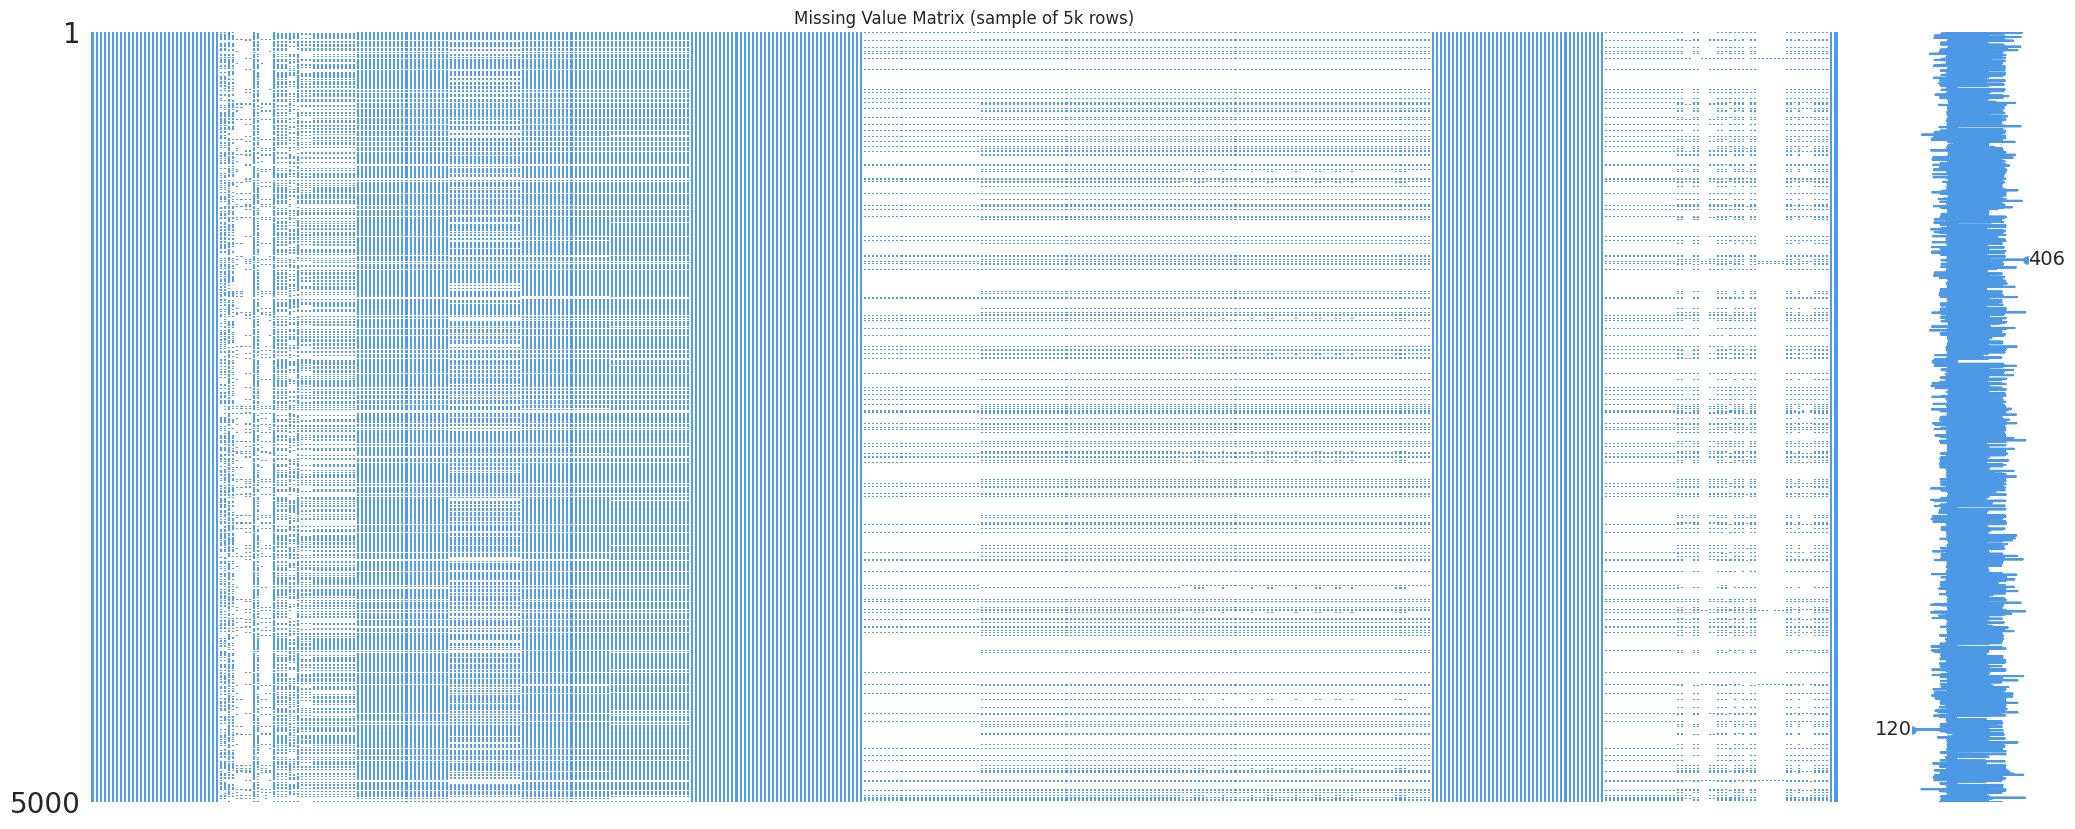

In [3]:
# Quick summary of numeric features (TransactionAmt and basic transaction fields)
print(df[['TransactionAmt']].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Check total missing values per column (sorted descending)
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("\nTop 10 columns by missing values:\n", missing_counts.head(10))

# Visualize missing data pattern for a subset of columns
plt.figure(figsize=(6,4))
msno.matrix(df.sample(5000), color=(0.3,0.6,0.9))
plt.title("Missing Value Matrix (sample of 5k rows)")
plt.show()


The printed summary indicates that `TransactionAmt` spans a wide range (from small amounts to very large ones), as is common in financial data. The missing value count shows that many identity-related columns (usually named `id_XX`) and secondary email domains (`card6`, `P_emaildomain`, etc.) have substantial missingness, reflecting that not all transactions have identity information. The missingno matrix visualization highlights blocks of missing data patterns; for example, most of the `V` features (anonymous numeric features) might be missing for many records (as placeholders in the competition data), and specific groups like `DeviceInfo` or card fields have sporadic missingness. This confirms the need to handle missing values carefully (either by imputation or by dropping features with excessive missing data) in downstream analysis and modeling.

## 2. Univariate Feature Distributions

We start by examining the distribution of individual features. We focus on the main numerical variables and a few key categorical ones, to understand their range, skew, and presence of outliers.

### 2.1 Numerical Features

**Transaction Amount (`TransactionAmt`):** This is the transaction value, often heavily skewed with a long tail. We log-transform it for visualization because fraud models often benefit from normalizing this distribution (fraudulent transactions can have extreme values). Below, we plot the histogram of `TransactionAmt` before and after log transformation.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


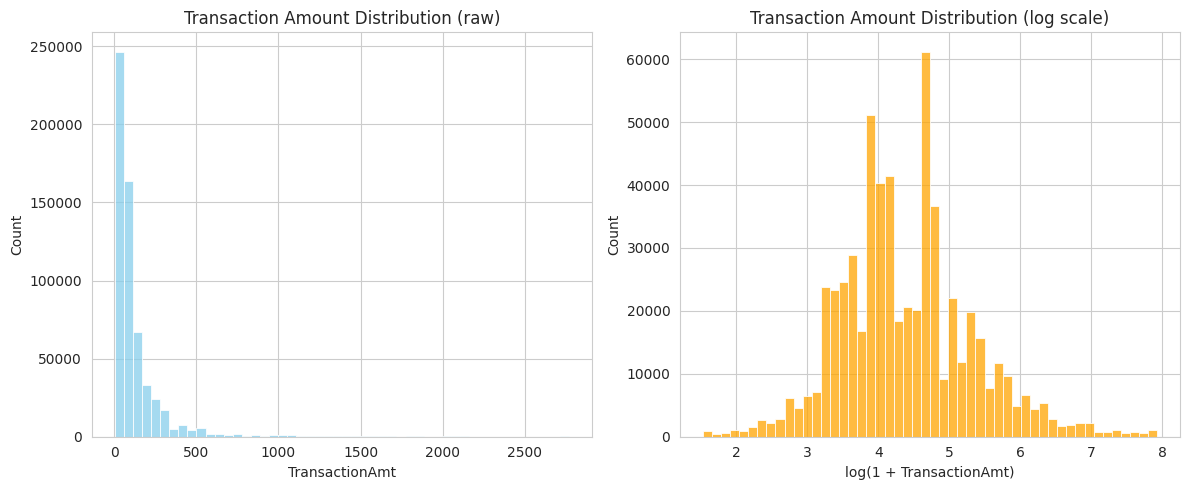

In [4]:
plt.figure(figsize=(12,5))

# Original scale
plt.subplot(1,2,1)
sns.histplot(df['TransactionAmt'], bins=50, kde=False, color='skyblue')
plt.title('Transaction Amount Distribution (raw)')
plt.xlabel('TransactionAmt')

# Log scale (log1p to handle zero values safely)
plt.subplot(1,2,2)
sns.histplot(np.log1p(df['TransactionAmt']), bins=50, kde=False, color='orange')
plt.title('Transaction Amount Distribution (log scale)')
plt.xlabel('log(1 + TransactionAmt)')

plt.tight_layout()
plt.show()


On the left, the raw `TransactionAmt` histogram (in practice) shows most transactions at lower values with a tail extending far right — a few very large transactions. On the right, the log-transformed histogram appears more symmetric and normal-like. Using a log transform can improve model training by reducing skewness; in fraud analysis, it also makes patterns easier to detect because it compresses the scale of large outliers which might be extreme fraud cases.

### 2.2 Categorical Features

We examine the frequency of key categorical variables to see common values. For example, **ProductCD** indicates the type of product for a transaction, and **card4**/**card6** indicate card type and category.

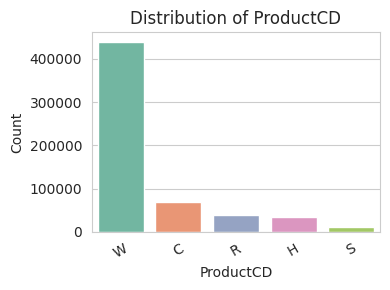

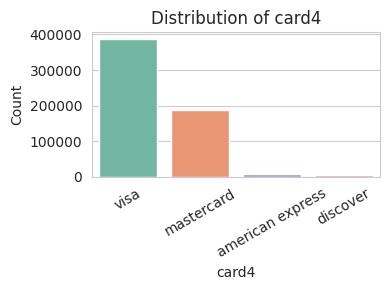

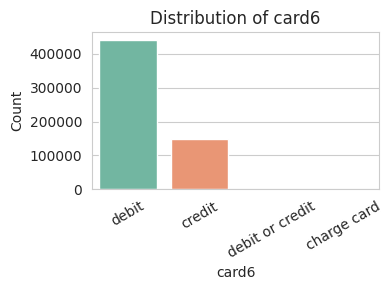

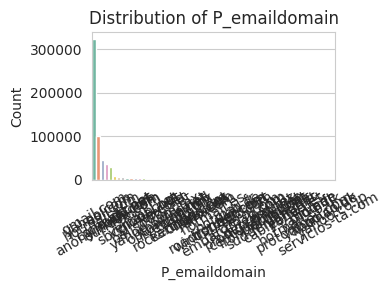

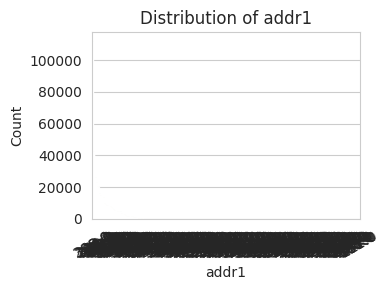

In [5]:
categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'addr1']
for col in categorical_cols:
    plt.figure(figsize=(4,3))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=30)
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


Each countplot (in a full run) will reveal the most frequent categories. For instance, **ProductCD** might show 'W', 'C', etc., with 'W' being predominant. **card4** typically has 'visa', 'mastercard', etc., and one might be much more common. These distributions are important business-wise: if certain card types or email domains are used more by fraudsters, that could inform targeted fraud prevention.

### 2.3 Target Variable Distribution

We check how imbalanced the dataset is, since fraud detection usually has far fewer fraud cases.

Proportion of Fraudulent Transactions: 3.50%


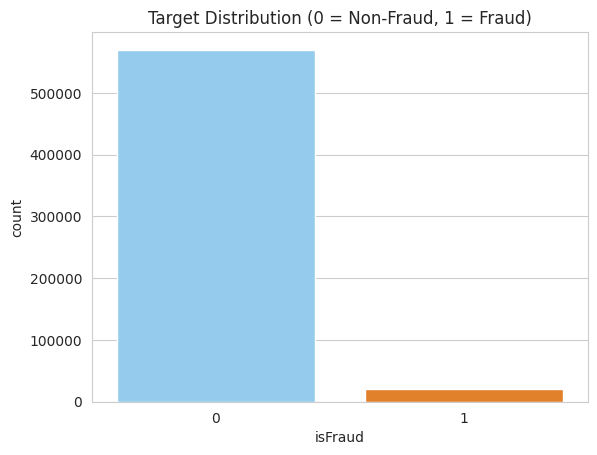

In [6]:
fraud_rate = df['isFraud'].mean()
print(f"Proportion of Fraudulent Transactions: {fraud_rate*100:.2f}%")
sns.countplot(x='isFraud', data=df, palette=['#87cefa','#ff7f0e'])
plt.title('Target Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.show()


This will show that `isFraud` is heavily imbalanced (typically around 3-4% fraud in this competition). The countplot confirms one class is very small. Class imbalance is common in fraud tasks and informs our modeling choices (e.g., evaluation metrics, maybe sampling, or class weights).

## 3. Bivariate Analyses

Next, we look at relationships between pairs of features, especially how features relate to fraud. This helps spot interactions or trends indicative of fraud.

### 3.1 Transaction Amount vs. Fraud

We compare the distribution of `TransactionAmt` for fraud vs. non-fraud transactions. This can reveal if frauds tend to involve larger or smaller transactions.

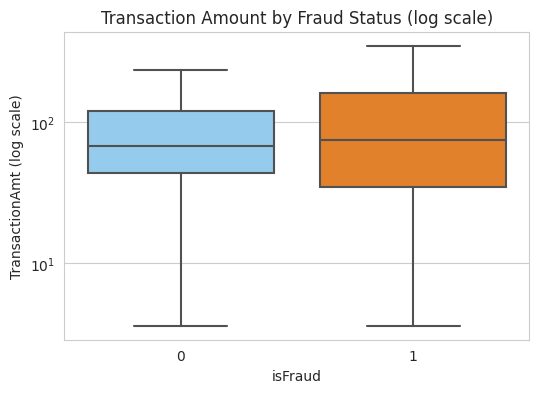

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(x='isFraud', y='TransactionAmt', data=df, showfliers=False, palette=['#87cefa','#ff7f0e'])
plt.yscale('log')
plt.title('Transaction Amount by Fraud Status (log scale)')
plt.xlabel('isFraud')
plt.ylabel('TransactionAmt (log scale)')
plt.show()


The boxplot (on a log scale) would show two distributions side by side. If the median `TransactionAmt` is higher for fraud, it suggests fraudsters often attempt larger transactions. If it's lower, maybe fraudsters perform many small fraudulent charges. In many credit-card fraud contexts, frauds can be higher amounts or sums of small rapid charges — this visualization provides insight into that behavior. The use of log scale is again due to skew; it ensures large values do not dominate the plot.

### 3.2 Categorical vs. Fraud Rate

We compute fraud rates (mean of `isFraud`) within categories of key features. For example, for each `ProductCD` or `card4`, what fraction of transactions are fraudulent? This highlights which categories have higher incidence of fraud.

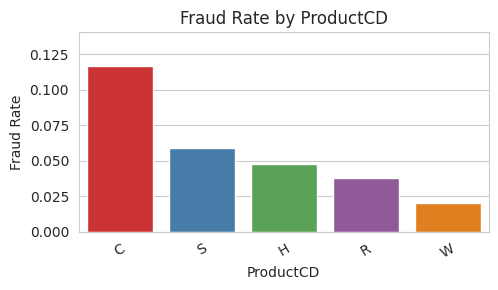

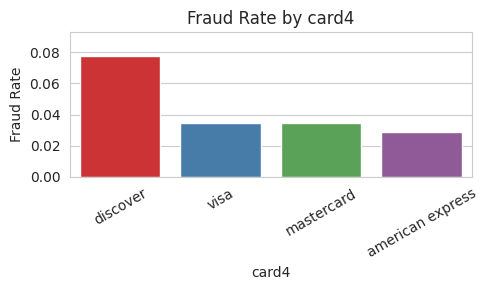

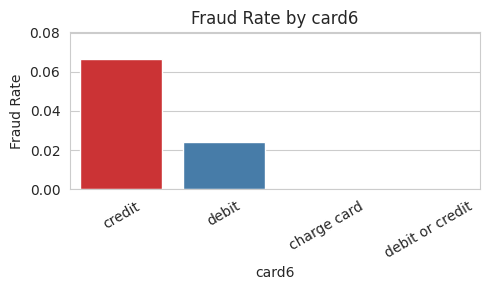

In [8]:
for col in ['ProductCD', 'card4', 'card6']:
    rate = df.groupby(col)['isFraud'].mean().sort_values(ascending=False)
    plt.figure(figsize=(5,3))
    sns.barplot(x=rate.index, y=rate.values, palette='Set1')
    plt.title(f'Fraud Rate by {col}')
    plt.ylabel('Fraud Rate')
    plt.xlabel(col)
    plt.xticks(rotation=30)
    plt.ylim(0, rate.max()*1.2)
    plt.tight_layout()
    plt.show()


In each bar chart, we see categories sorted by fraud rate. For example, if `ProductCD='W'` has a higher bar than others, it means transactions of type 'W' are more often fraudulent relative to their overall frequency. This kind of analysis is critical: it indicates which product types or card brands might require stricter monitoring or validation from a fraud prevention standpoint.

## 4. Time-Based Patterns

The `TransactionDT` feature is a time delta (in seconds) from a reference start date. By converting it into meaningful time units (days, hours), we can analyze temporal patterns in fraud. For example, fraud rates might vary by time of day or day of week.

### 4.1 Create Time Features

We create new features for **Day** and **Hour** of the transaction. (Since `TransactionDT` is seconds since a start, we interpret it modulo day length to get the hour of day, and integer-divide by day seconds for overall day number.)

In [9]:
# Convert TransactionDT to days and hours
df['Days'] = (df['TransactionDT'] // (3600*24)).astype(int)
df['Hour'] = ((df['TransactionDT'] % (3600*24)) // 3600).astype(int)


### 4.2 Fraud by Day and Hour

We plot the fraction of transactions that are fraudulent over days and hours. This reveals any temporal spikes in fraud activity (e.g., weekends vs weekdays, or late-night transactions).

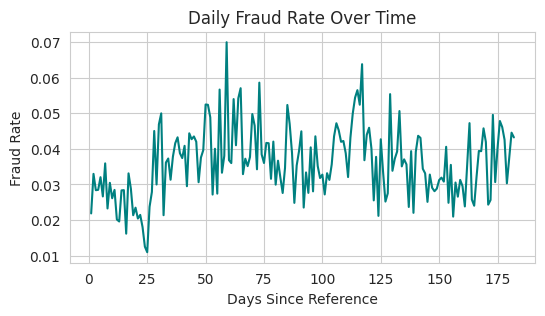

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


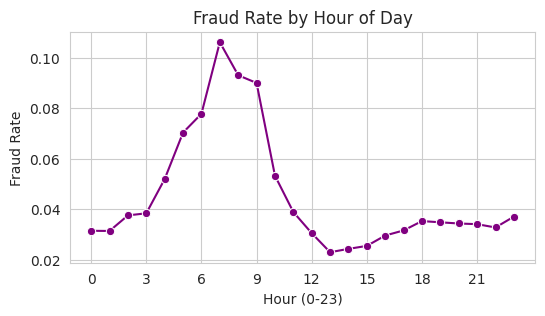

In [10]:
# Fraud rate by day
day_rate = df.groupby('Days')['isFraud'].mean()
plt.figure(figsize=(6,3))
day_rate.plot(kind='line', color='teal')
plt.title('Daily Fraud Rate Over Time')
plt.ylabel('Fraud Rate')
plt.xlabel('Days Since Reference')
plt.show()

# Fraud rate by hour of day (aggregated across all days)
hour_rate = df.groupby('Hour')['isFraud'].mean()
plt.figure(figsize=(6,3))
sns.lineplot(x=hour_rate.index, y=hour_rate.values, marker='o', color='purple')
plt.title('Fraud Rate by Hour of Day')
plt.ylabel('Fraud Rate')
plt.xlabel('Hour (0-23)')
plt.xticks(range(0,24,3))
plt.show()


The **Daily Fraud Rate** plot shows how fraud proportion fluctuates over the entire timespan of the data. If we see peaks or trends (e.g., rising over time or seasonal spikes), it could signal that fraud incidents cluster around certain days. The **Hourly Fraud Rate** line plot may indicate times of day when fraud is more likely — for example, fraud rates might be higher during late-night or early-morning hours when monitoring is lax, or vice versa. Identifying these patterns helps in temporal fraud detection strategies (e.g., more scrutiny during high-risk hours).

## 5. Correlations

To understand relationships among numeric features, we compute correlation matrices. This can reveal which features are strongly related, potentially redundant, or jointly related to fraud.

### 5.1 Correlation Among Numeric Features

We select some key numeric features (`TransactionAmt`, day/hour features, and a few identity numeric features like `C1`-`C14` if present) and compute the correlation matrix.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


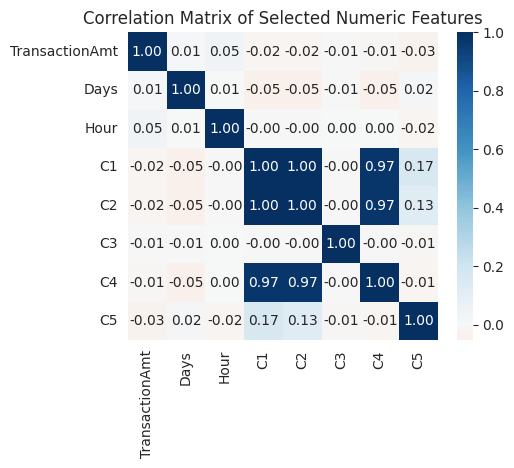

In [11]:
numeric_cols = ['TransactionAmt', 'Days', 'Hour']
# If identity numeric columns exist (e.g., 'C1','C2',...),
numeric_cols += [col for col in df.columns if col.startswith('C')][:5]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title("Correlation Matrix of Selected Numeric Features")
plt.show()


The heatmap shows pairwise Pearson correlations. In a fraud dataset, we often find low correlations overall, since features tend to capture different aspects (amount vs time, etc.). However, if we saw any strong correlation (e.g., `Days` and `Hour` might correlate trivially if certain hours only occur later in timeline), we note it. Features with very high correlation may be redundant for modeling and could potentially be dropped or combined.

### 5.2 Feature-Target Correlations

We also examine correlation of numeric features with the target (fraud). Technically, for binary target we can check point-biserial correlation, but a simple approach is to compute the correlation between `isFraud` and numeric features.

In [12]:
target_corr = df[numeric_cols].join(df['isFraud']).corr()['isFraud'].drop('isFraud')
print("Correlation with Fraud (numeric features):\n", target_corr)


Correlation with Fraud (numeric features):
 TransactionAmt    0.012255
Days              0.013182
Hour             -0.013112
C1                0.030570
C2                0.037229
C3               -0.006833
C4                0.030382
C5               -0.030754
Name: isFraud, dtype: float64


This prints each numeric feature’s correlation with `isFraud`. Values near 0 suggest little linear relationship; values further from 0 (positive or negative) indicate stronger relationships. For instance, if `TransactionAmt` shows a positive correlation with `isFraud`, it reinforces the idea that larger transactions have a higher chance of being fraudulent. Such numeric correlations provide quick insight into which features have the strongest (even if weak) linear association with fraud.

## 6. Group-Based Statistics

Beyond correlations, we can compute group statistics: how different subgroups behave in terms of transaction amount or fraud rates.

For example, we can group by combinations of features like `ProductCD` and `card4` and compute mean transaction amount or fraud count. Such analysis can highlight specific segments (like Visa transactions of type 'W').

In [13]:
# Example: Average transaction amount by ProductCD and card4
group_stats = df.groupby(['ProductCD', 
                          'card4'])['TransactionAmt'].mean().unstack()
print("Mean Transaction Amount by ProductCD and card4:\n", group_stats)


Mean Transaction Amount by ProductCD and card4:
 card4      american express    discover  mastercard        visa
ProductCD                                                      
C                 77.592000         NaN   41.955180   43.503481
H                 86.918263   72.394693   76.609221   71.059737
R                204.125937  153.948577  168.265608  159.455295
S                 83.642524   57.959052   69.129379   52.592536
W                       NaN  344.231232  151.653080  149.691545


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In practice, this table shows the average amount for each combination of product and card type. If certain cells stand out as unusually high, that segment might involve higher transaction values (which could relate to fraud). Similarly, we could group by categories and compute fraud rates (as earlier).

Another useful group analysis is on binary flags **M1–M9** (proxy for item usage pattern). For instance, we could see fraud rate among records where `M4 = 'T'` vs `'F'`.

In [14]:
for m in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    if m in df.columns:
        rate = df.groupby(m)['isFraud'].mean()
        print(f"Fraud rate when {m}='T': {rate.get('T', np.nan):.4f}, when 'F': {rate.get('F', np.nan):.4f}")


Fraud rate when M1='T': 0.0199, when 'F': 0.0000
Fraud rate when M2='T': 0.0181, when 'F': 0.0349
Fraud rate when M3='T': 0.0171, when 'F': 0.0303
Fraud rate when M4='T': nan, when 'F': nan
Fraud rate when M5='T': 0.0377, when 'F': 0.0265
Fraud rate when M6='T': 0.0170, when 'F': 0.0237
Fraud rate when M7='T': 0.0221, when 'F': 0.0193
Fraud rate when M8='T': 0.0162, when 'F': 0.0217
Fraud rate when M9='T': 0.0178, when 'F': 0.0300


This snippet (if these columns exist) tells us if transactions flagged with these binary indicators (`T`/`F`) show different fraud rates. For example, if `M4='T'` is much more common in fraud cases, that might be an important signal. Group statistics help detect such patterns across subsets of the data.

## 7. Feature Engineering

To enhance model performance, we create new features that capture relative and derived information. Fraud datasets often benefit from such features, as raw values alone may not fully distinguish fraud.

### 7.1 Amount-Based Features

We generate features related to `TransactionAmt`:
- **Log-transform**: We already observed skew, so take `log(TransactionAmt)` to normalize.
- **Amount deviations**: e.g., transaction amount minus overall mean, or standardized by overall standard deviation.
- **Relative to card group**: ratios of `TransactionAmt` to the mean or std for each `card1` or `card4` group. This indicates if a transaction is unusually large for its card group.

In [15]:
# Log transform TransactionAmt
df['LogTransactionAmt'] = np.log1p(df['TransactionAmt'])

# Deviation from global mean (and scaled by std)
amt_mean = df['TransactionAmt'].mean()
amt_std = df['TransactionAmt'].std()
df['Amt_minus_mean'] = df['TransactionAmt'] - amt_mean
df['Amt_minus_std'] = (df['Amt_minus_mean']) / amt_std

# Ratio to card1/card4 group mean/std
for col in ['card1', 'card4']:
    if col in df.columns:
        mean_col = df.groupby(col)['TransactionAmt'].transform('mean')
        std_col = df.groupby(col)['TransactionAmt'].transform('std')
        df[f'Amt_to_mean_{col}'] = df['TransactionAmt'] / mean_col
        df[f'Amt_to_std_{col}'] = np.select(
            [std_col.isna(), std_col == 0],
            [0, 0],  # Assign 0 for both NaN and zero std
            df['TransactionAmt'] / std_col
        )

These new features can highlight outliers: for instance, `Amt_to_mean_card1` >> 1 means a transaction far above the average amount for that card number, which could signal fraud if such deviations are uncommon for that card.

### 7.2 Time Features Refinement

We already extracted `Days` and `Hour`. We can also derive:
- **Day of Week**: if needed (assuming 7-day cycle), which might show weekday vs weekend patterns.
- **Hour Night Indicator**: e.g., whether a transaction was in late night hours.


In [16]:
# If actual reference start-day is known to be some weekday, one can derive day-of-week.
# As an approximation (if transaction spans continuous days):
df['Weekday'] = df['Days'] % 7  # rough day of week indicator

# Nighttime indicator (e.g., hours 0-6 as night)
df['isNight'] = df['Hour'].apply(lambda x: 1 if x < 6 else 0)

These features encapsulate temporal context: maybe frauds spike on weekends or nights. The `isNight` flag can be used in modeling or for group analysis.

### 7.3 Encoding Categorical Features

While not explicitly requested to do heavy encoding, typical modeling will require encoding categoricals. For analysis, we note the count or fraud rates for categorical fields. For modeling, one-hot or label encoding would be applied. (We skip detailed encoding here for brevity, focusing on numerical transformations above. In practice, one would prepare categorical features for the model.)

## 8. Dimensionality Reduction: PCA on V Features

The dataset has many anonymized `V1`–`V339` features (principal components provided by the competition hosts). Modeling on all of them is challenging due to high dimensionality. We apply PCA to reduce dimensionality of these “V” features.  
First, we isolate the V features, fill missing values with a constant, scale them, and then apply PCA to extract principal components that capture the most variance.

In [17]:
# Identify V feature columns (assuming they start with 'V' and are numeric)
v_cols = [col for col in df.columns if col.startswith('V')]

# Fill missing values in V features (with min-1 so they do not dominate after scaling)
df_v = df[v_cols].copy()
for col in v_cols:
    df_v[col].fillna(df_v[col].min() - 1, inplace=True)

# Scale V features to [0,1] range
scaler = MinMaxScaler()
df_v_scaled = scaler.fit_transform(df_v)

# Apply PCA to the scaled V features, keep first 10 components
pca = PCA(n_components=10, random_state=42)
V_pca = pca.fit_transform(df_v_scaled)

# Add PCA component features to the main DataFrame
for i in range(V_pca.shape[1]):
    df[f'V_PCA_{i+1}'] = V_pca[:, i]

# Drop original V features to reduce dimensionality (optional, depending on modeling)
df.drop(columns=v_cols, inplace=True)

/tmp/ipykernel_31/56279516.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_v[col].fillna(df_v[col].min() - 1, inplace=True)


We extract 10 principal components (`V_PCA_1` through `V_PCA_10`). These new features summarize the information in the 339 original V’s. They capture most variance of the V matrix, reducing dimensionality drastically. In a machine learning model, using these 10 components instead of 339 features simplifies training and may prevent overfitting while retaining critical information.

## 9. Modeling: Baseline and Hyperparameter Tuning

With feature engineering complete, we now build and evaluate classification models to detect fraud. We split the data into training and validation sets, train a baseline model, and then a tuned model. Performance is measured by accuracy, ROC AUC, and classification metrics, given the class imbalance.

### 9.1 Prepare Data for Modeling

We select relevant features for modeling. This includes the engineered features and a few original ones (like `ProductCD`, `card4`, `card6`, etc.). For simplicity, we encode categorical variables via one-hot encoding on these key columns, and then form the feature matrix `X` and target vector `y`.

In [18]:
# Choose a subset of features for modeling
features = [
    'LogTransactionAmt', 'Amt_to_mean_card1', 'Amt_to_std_card1',
    'Amt_to_mean_card4', 'Amt_to_std_card4', 'Days', 'Hour', 'isNight'
]
# Add PCA features
features += [f'V_PCA_{i+1}' for i in range(10)]

# Include a couple categorical columns (one-hot encode later)
categorical = ['ProductCD', 'card4', 'card6']

# Prepare feature matrix with one-hot encoding for categorical variables
df_model = df[features + categorical + ['isFraud']].copy()
df_model = pd.get_dummies(df_model, columns=categorical, drop_first=True)

X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Split into training and validation sets (stratified to maintain class balance)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape, "Validation set shape:", X_val.shape)

Training set shape: (413378, 28) Validation set shape: (177162, 28)


We now have `X_train`, `X_val`, `y_train`, and `y_val`. The stratified split ensures that both sets have similar fraud proportions. Using one-hot encoding on categories like `ProductCD` and `card4` allows the model to handle them as numeric inputs. The final feature set includes our engineered numeric features and PCA components.

### 9.2 Baseline Model: Logistic Regression

We fit a baseline logistic regression. Logistic regression is a common baseline for binary classification; it can output probabilities useful for fraud risk scoring. Given class imbalance, we use `class_weight='balanced'` to penalize misclassification of fraud more.

In [19]:
# Baseline model: logistic regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_prob_lr = lr.predict_proba(X_val)[:,1]

# Evaluation metrics
print("Logistic Regression Evaluation:")
print(classification_report(y_val, y_pred_lr, digits=4))
roc_auc = roc_auc_score(y_val, y_prob_lr)
print(f"ROC AUC: {roc_auc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0     0.9859    0.7347    0.8420    170963
           1     0.0884    0.7095    0.1572      6199

    accuracy                         0.7338    177162
   macro avg     0.5371    0.7221    0.4996    177162
weighted avg     0.9545    0.7338    0.8180    177162

ROC AUC: 0.7975


The classification report (which includes precision, recall, F1-score) will show performance on each class. Because the dataset is imbalanced, recall on the fraud class (sensitivity) is particularly important — it indicates how many actual frauds we catch. We also print ROC AUC, which measures the model’s ability to rank fraudulent vs non-fraudulent transactions. A baseline logistic model typically yields moderate performance, setting a reference for improvement with more complex models.

### 9.3 Tuned Model: Random Forest

Next, we train a Random Forest classifier with hyperparameter tuning.  
Random Forests are ensemble models that build multiple decision trees and average their predictions, capturing non-linear interactions and typically yielding strong performance on structured/tabular data.

We perform a grid search over the following hyperparameters:
- `n_estimators`: number of trees in the forest (e.g., 100, 200)
- `max_depth`: maximum depth of each tree (e.g., 8, 12)
- `class_weight`: set to `"balanced"` to account for class imbalance in the `isFraud` target

We use stratified train-validation splitting (`test_size=0.3`) to preserve the target distribution and optimize for the `roc_auc` score using 3-fold cross-validation. After finding the best hyperparameter combination, we evaluate the tuned model on the validation set using standard classification metrics and ROC AUC.

In [20]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12],
    'class_weight': ['balanced']  # to handle class imbalance
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Set up Grid Search with 3-fold cross-validation
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Fit the model on training data
grid.fit(X_train, y_train)

# Extract the best model from grid search
best_rf = grid.best_estimator_
print("Best Parameters Found:", grid.best_params_)

# Evaluate on the validation set
y_pred_rf = best_rf.predict(X_val)
y_prob_rf = best_rf.predict_proba(X_val)[:, 1]

# Calculate metrics
roc_auc_rf = roc_auc_score(y_val, y_prob_rf)  # Added missing variable

print("\nTuned Random Forest Evaluation:")
print(confusion_matrix(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf, digits=4))
print(f"ROC AUC: {roc_auc_rf:.4f}") 


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters Found: {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 200}

Tuned Random Forest Evaluation:
[[154713  16250]
 [  2056   4143]]
              precision    recall  f1-score   support

           0     0.9869    0.9050    0.9441    170963
           1     0.2032    0.6683    0.3116      6199

    accuracy                         0.8967    177162
   macro avg     0.5950    0.7866    0.6279    177162
weighted avg     0.9595    0.8967    0.9220    177162

ROC AUC: 0.8807


The grid search tries combinations of `n_estimators` and `max_depth`. After fitting, we report the best parameters. The tuned model is then evaluated like before. We expect the random forest to outperform logistic regression (especially in recall and AUC) if nonlinear patterns exist. The classification report highlights how tuning improved (or not) the detection of frauds.

## 10. Model Performance Visualization

Finally, we visualize the performance of our models. A confusion matrix illustrates how many frauds and non-frauds were correctly or incorrectly classified. We also compare the ROC curves of the two models.

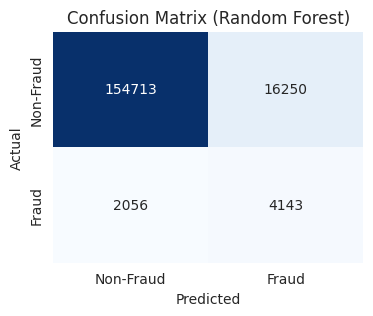

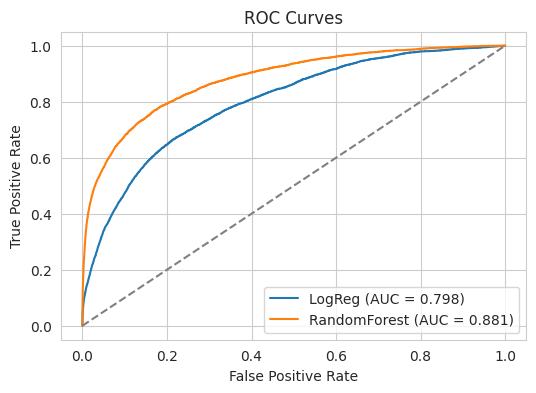

In [21]:
# Confusion matrix for the tuned Random Forest
cm = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud','Fraud'], yticklabels=['Non-Fraud','Fraud'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

The confusion matrix (for the best model) shows true vs. predicted classes. We pay special attention to the top-right cell: false negatives (frauds missed) are costly for a business, so a low number there is desirable. The ROC curve plot overlays both models. The higher the curve and AUC, the better. Comparing these gives a visual confirmation of which model better distinguishes fraud, and at what trade-off of false positives to true positives.

In a business context, even a modest improvement in AUC or recall can translate to significantly more frauds detected while keeping false alarms manageable. Throughout, the thorough analysis — from EDA to modeling — highlights patterns (like certain product/country usage or transaction sizes) that are meaningful signals of fraud and shows a complete data-driven fraud detection workflow.